In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
def plotting(path='cubicspline_vary_sparsity0_0_3_3_0_20.csv'):
    oper_char_df = pd.read_csv(path)
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()

    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))

    print("Mean coverage rate/length:")
    print(oper_char_df.groupby(['sparsity size', 'method']).mean())

    cov_plot = sns.boxplot(y=oper_char_df["coverage rate"],
                           x=oper_char_df["sparsity size"],
                           hue=oper_char_df["method"],
                           palette="pastel",
                           orient="v", ax=ax1,
                           linewidth=1)
    cov_plot.set(title='Coverage')
    cov_plot.set_ylim(0.6, 1.05)
    # plt.tight_layout()
    cov_plot.axhline(y=0.9, color='k', linestyle='--', linewidth=1)
    # ax1.set_ylabel("")  # remove y label, but keep ticks

    len_plot = sns.boxplot(y=oper_char_df["avg length"],
                           x=oper_char_df["sparsity size"],
                           hue=oper_char_df["method"],
                           palette="pastel",
                           orient="v", ax=ax2,
                           linewidth=1)
    len_plot.set(title='Length')
    # len_plot.set_ylim(0, 100)
    # len_plot.set_ylim(0, 8)
    # plt.tight_layout()
    # ax2.set_ylabel("")  # remove y label, but keep ticks

    handles, labels = ax2.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)
    fig.subplots_adjust(bottom=0.2)
    fig.legend(handles, labels, loc='lower center', ncol=4)

    F1_plot = sns.boxplot(y=oper_char_df["F1 score"],
                          x=oper_char_df["sparsity size"],
                          hue=oper_char_df["method"],
                          palette="pastel",
                          orient="v", ax=ax3,
                          linewidth=1)
    F1_plot.set(title='F1 score')

    cov_plot.legend_.remove()
    len_plot.legend_.remove()
    F1_plot.legend_.remove()

    plt.show()

Mean coverage rate/length:
                              coverage rate  avg length  F1 score
sparsity size method                                             
2             Data splitting       0.929160  271.410026  0.025098
              MLE                  0.892554  212.303843  0.072005
              Naive                0.863360  124.524950  0.115404
5             Data splitting       0.888561  262.225350  0.133680
              MLE                  0.901432  212.792657  0.166301
              Naive                0.900694  117.115819  0.174785
10            Data splitting       0.883238  269.943124  0.208626
              MLE                  0.868132  207.025928  0.247942
              Naive                0.953426  122.126561  0.159453


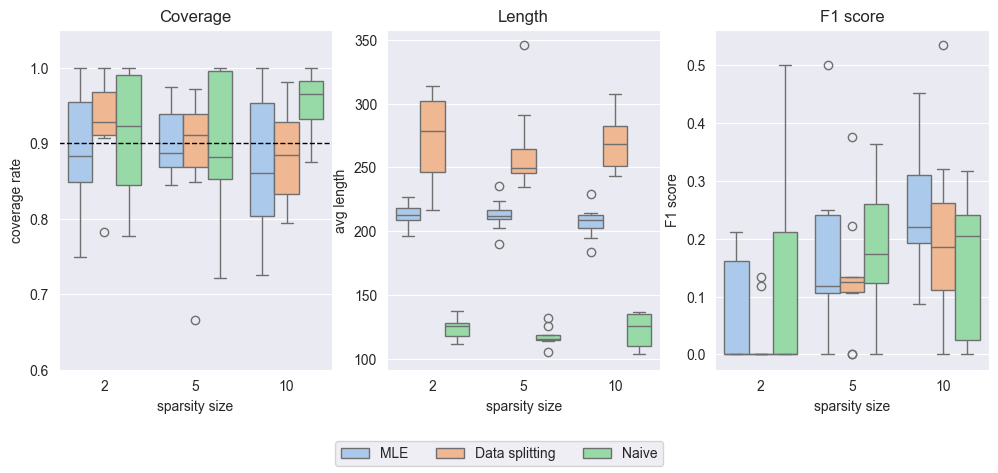

In [32]:
plotting('cubicspline_vary_sparsity0_0_3_3_0_10.csv')

In [92]:
def CI_to_oper_char(CI_path, oper_char_path, iter_num,
                    methods=['MLE', 'Data splitting', 'Naive']):

    def CI_to_oper_char_entry(df_instance, method):
        # Function to calculate F1 score based on CI
        def get_interval_F1(TP, LCB, UCB, sparsity_size):
            group_size = 4
            TP_inf_count = ((TP == True) & ((0 < LCB) | (0 > UCB))).sum()
            FP_inf_count = ((TP == False) & ((0 < LCB) | (0 > UCB))).sum()
            FN_inf_count = sparsity_size * group_size - TP_inf_count
            F1_inf = TP_inf_count / (TP_inf_count+0.5*(FP_inf_count+FN_inf_count))
            if TP_inf_count + FP_inf_count > 0:
                prec = TP_inf_count / (TP_inf_count + FP_inf_count)
            else:
                prec = 0
            recall = TP_inf_count / (TP_inf_count + FN_inf_count)
            return F1_inf, prec, recall

        def get_sel_F1(TP, sparsity_size):
            group_size = 4
            FP = (TP == False).sum()
            FN = sparsity_size * group_size - TP.sum()
            prec = TP.sum() / (TP.sum() + FP)
            recall = TP.sum() / (TP.sum() + FN)
            return prec, recall

        method_flag = (df_instance['Method'] == method)
        df_instance_m = df_instance.loc[method_flag]

        sparsity_size = (df_instance_m['sparsity size'].to_numpy())[0]
        F1 = (df_instance_m['F1'].to_numpy())[0]
        target = df_instance_m['target'].to_numpy()
        LCB = df_instance_m['LCB'].to_numpy()
        UCB = df_instance_m['UCB'].to_numpy()
        TP = df_instance_m['TP'].to_numpy()
        prec, recall = get_sel_F1(TP, sparsity_size)
        F1_CI, prec_CI, recall_CI = get_interval_F1(TP, LCB, UCB, sparsity_size)

        coverage = (target > LCB) * (target < UCB)
        length = UCB - LCB
        cov_rate = np.mean(coverage)
        avg_len = np.mean(length)

        row = pd.DataFrame([sparsity_size, cov_rate, avg_len, method, F1, prec, recall,
                            F1_CI, prec_CI, recall_CI]).T
        return row


    CI_df = pd.read_csv(CI_path)
    oper_char_df = pd.DataFrame()

    sparsity = CI_df['sparsity size']
    for s in [5,8,10]:
        s_flag = (sparsity == s)
        df_s = CI_df.loc[s_flag]
        for i in range(iter_num):
            indices = df_s['Index']
            i_s_flag = (indices == i)
            df_i_s = df_s.loc[i_s_flag]

            for m in methods:
                row = CI_to_oper_char_entry(df_i_s, m)
                oper_char_df = pd.concat([oper_char_df, row], axis=0)

    colnames = ['sparsity size'] + ['coverage rate'] + ['avg length'] + ['method'] + ['F1 score'] + ['prec'] + ['recall'] + ['F1 score (CI)'] + ['prec (CI)'] + ['recall (CI)']
    oper_char_df.columns = colnames

    oper_char_df.to_csv(oper_char_path,index=False)

    return oper_char_df

In [93]:
logis_oper_char = CI_to_oper_char(CI_path="logis_CI_vary_sparsity.csv",
                                  oper_char_path="logis_vary_sparsity_F1CI.csv",
                                  iter_num = 100)

In [94]:
print(logis_oper_char)

   sparsity size coverage rate avg length          method  F1 score      prec  \
0            5.0         0.925  12.696239             MLE       0.4       0.3   
0            5.0      0.958333  14.922998  Data splitting  0.181818  0.166667   
0            5.0           0.5   6.718808           Naive       0.0       0.0   
0            5.0           0.7  11.584122             MLE       0.2       0.2   
0            5.0      0.821429  14.657522  Data splitting       0.0       0.0   
..           ...           ...        ...             ...       ...       ...   
0           10.0          0.75  14.771204  Data splitting  0.266667       0.4   
0           10.0      0.833333   7.475357           Naive  0.307692  0.666667   
0           10.0       0.96875  12.224294             MLE  0.333333     0.375   
0           10.0      0.888889  17.502183  Data splitting  0.105263  0.111111   
0           10.0           0.7   7.628583           Naive  0.266667       0.4   

   recall F1 score (CI) pre

Mean coverage rate/length:
                              coverage rate  avg length  F1 score      prec  \
sparsity size method                                                          
5.0           Data splitting       0.888223   15.490848  0.157958  0.143118   
              MLE                  0.911106   12.427691  0.169706  0.147804   
              Naive                0.688119    7.198598  0.141335  0.222857   
8.0           Data splitting       0.877031   15.849517  0.223220  0.246615   
              MLE                  0.897594   12.435640  0.216874  0.229514   
              Naive                0.720920    7.396837  0.194544  0.363905   
10.0          Data splitting       0.859327   16.199244  0.247063  0.297755   
              MLE                  0.900659   12.535648  0.272564  0.332866   
              Naive                0.729253    7.474542  0.213949  0.444937   

                               recall  F1 score (CI)  prec (CI)  recall (CI)  
sparsity size method    

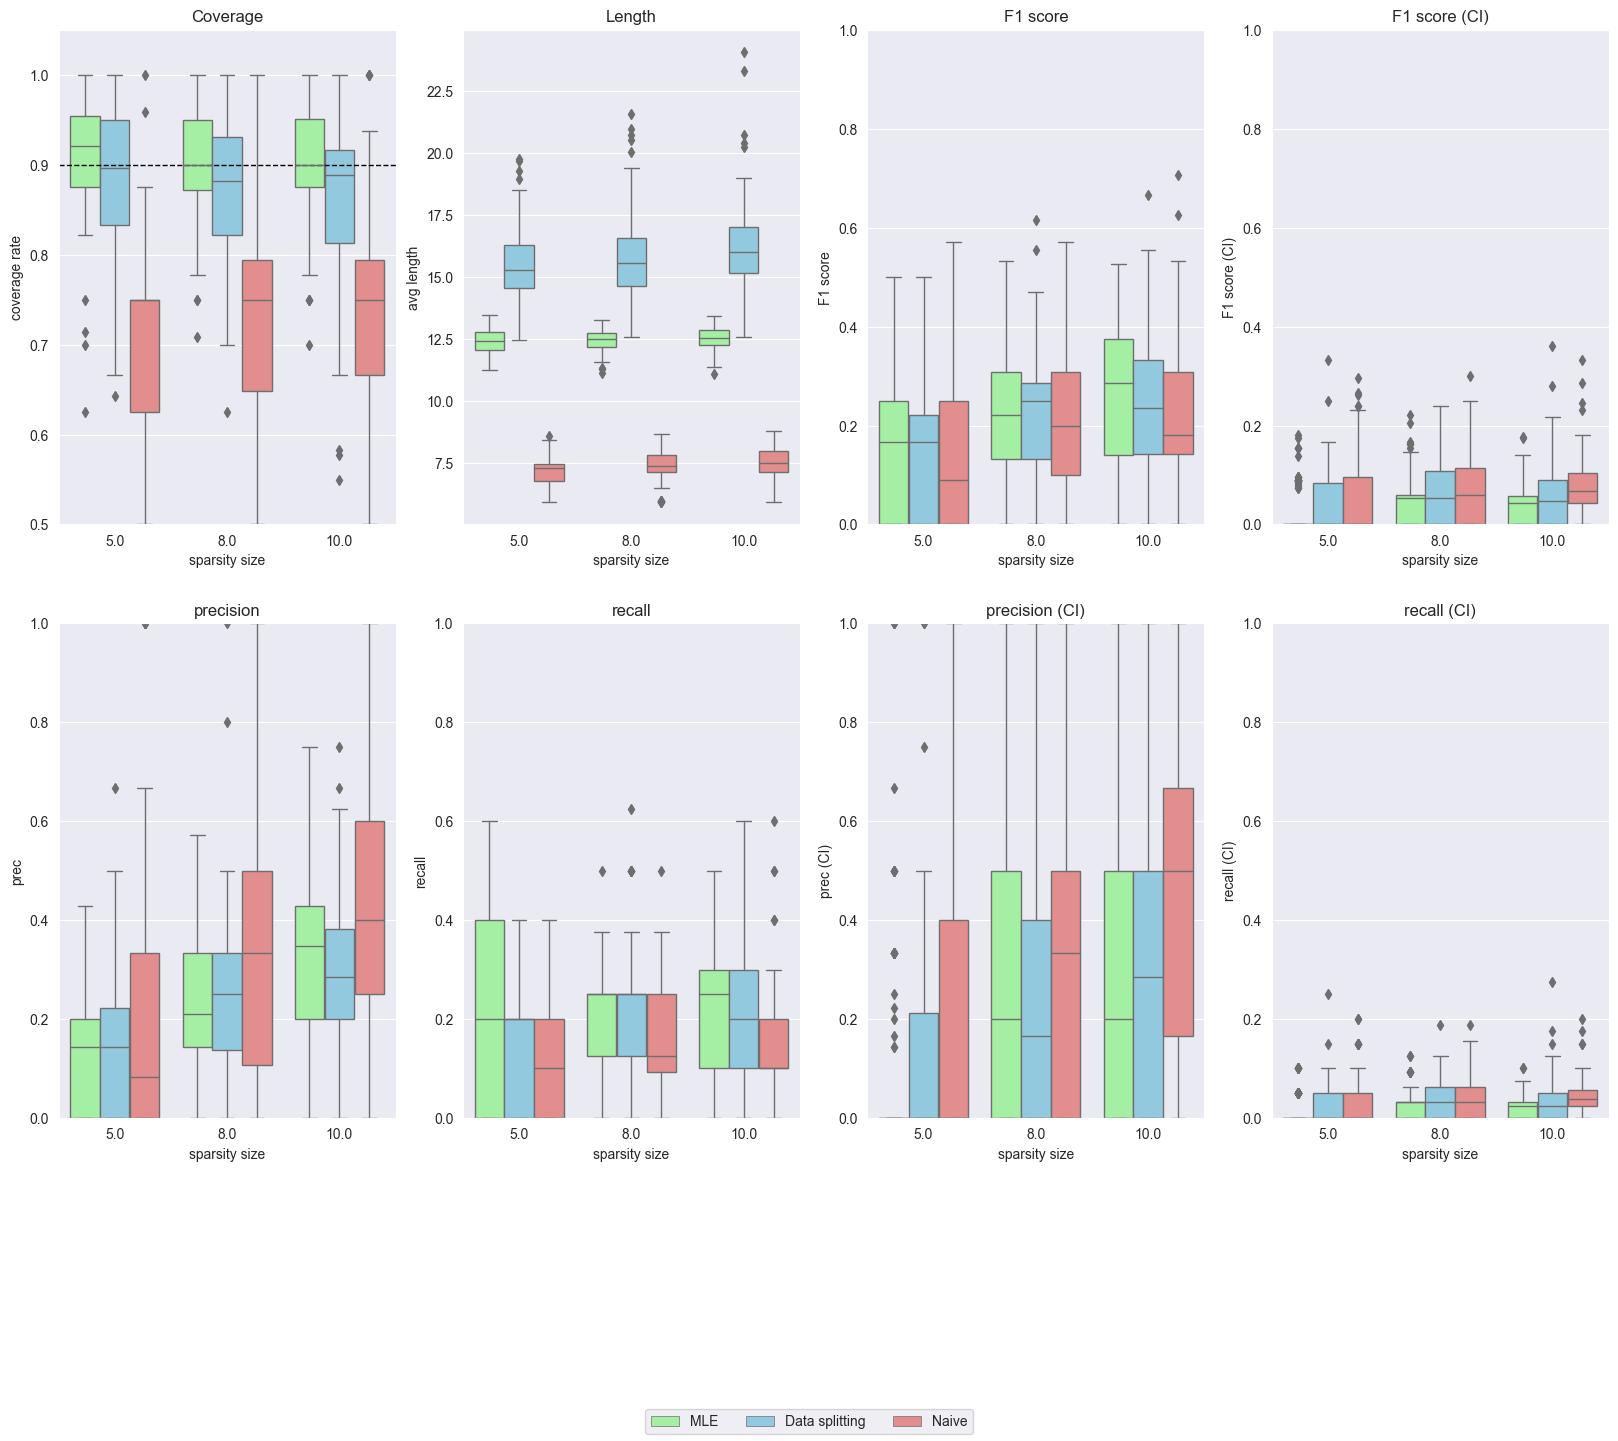

In [105]:
plotting(oper_char_df = logis_oper_char)

In [107]:
F1CI_nonzero = logis_oper_char["F1 score (CI)"] != 0
logis_oper_char_trunc = logis_oper_char[F1CI_nonzero]

In [108]:
F1CI_nonzero.mean()

0.5333333333333333

In [109]:
logis_oper_char_trunc.shape

(480, 10)

In [110]:
480/900

0.5333333333333333

Mean coverage rate/length:
                              coverage rate  avg length  F1 score      prec  \
sparsity size method                                                          
5.0           Data splitting       0.846394   16.192466  0.219830  0.195009   
              MLE                  0.884089   12.478092  0.251626  0.220291   
              Naive                0.701283    7.267418  0.288345  0.462275   
8.0           Data splitting       0.844568   16.161493  0.295680  0.324549   
              MLE                  0.880304   12.483593  0.257032  0.273234   
              Naive                0.731093    7.450428  0.258973  0.492774   
10.0          Data splitting       0.845285   16.534635  0.291986  0.349053   
              MLE                  0.885132   12.579963  0.323150  0.386284   
              Naive                0.748142    7.546298  0.264671  0.549705   

                                recall  F1 score (CI)  prec (CI)  recall (CI)  
sparsity size method   

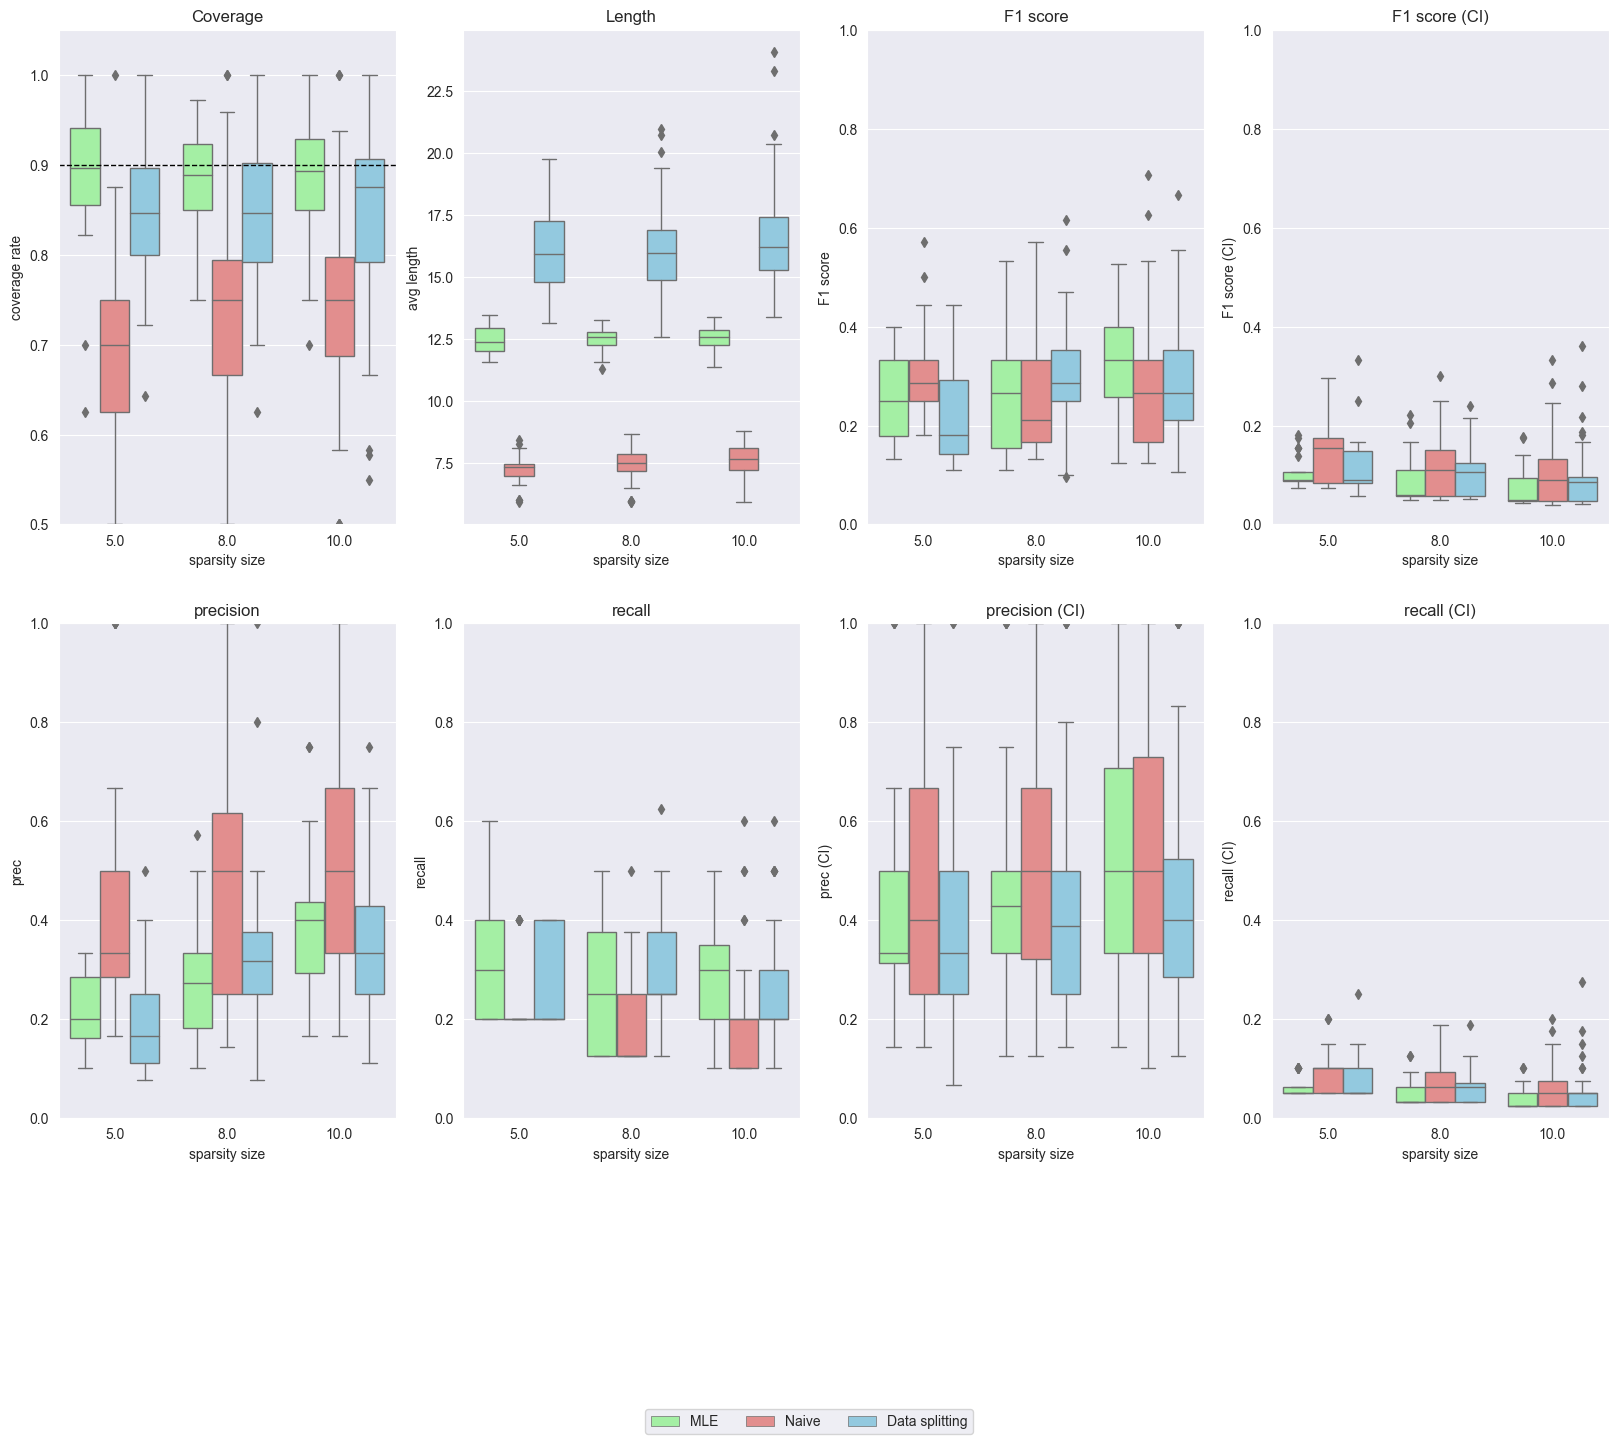

In [111]:
plotting(oper_char_df = logis_oper_char_trunc)